In [11]:

import pandas as pd
import numpy as np
from pckgs.helper import timeseries_to_supervised, PnlCallback
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Reshape, Conv1D,concatenate ,Dropout,dot
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Model

from tensorflow.keras.regularizers import l1, l2
import matplotlib.pyplot as plt
import seaborn as sb
from pckgs.headline_preprocess import HeadlinePreprocess

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
price = pd.read_csv('../Price/datasets/bitcoin_position_day_20_thres1.csv', parse_dates=['Timestamp'])
price.rename(columns={'Timestamp':'date'}, inplace=True)
price.set_index('date', inplace=True)
y = price.loc[:,['down', 'same', 'up']]
x1 = price.drop(['down', 'same', 'up'], axis=1)
x1

,pChange_scaled_t-1,pChange_scaled_t-2,pChange_scaled_t-3,pChange_scaled_t-4,pChange_scaled_t-5,pChange_scaled_t-6,pChange_scaled_t-7,pChange_scaled_t-8,pChange_scaled_t-9,pChange_scaled_t-10,pChange_scaled_t-11,pChange_scaled_t-12,pChange_scaled_t-13,pChange_scaled_t-14,pChange_scaled_t-15,pChange_scaled_t-16,pChange_scaled_t-17,pChange_scaled_t-18,pChange_scaled_t-19,pChange_scaled_t-20
date,,,,,,,,,,,,,,,,,,,,
2016-01-22,-0.314641,0.243533,-0.344497,-0.175584,-0.320540,0.104178,-0.986057,-0.273074,-0.263584,-0.375391,-0.248281,-0.240685,-0.279451,-0.283517,0.054100,-0.270746,-0.258634,-0.206721,-0.266842,-0.243039
2016-01-23,-0.544293,-0.314641,0.243533,-0.344497,-0.175584,-0.320540,0.104178,-0.986057,-0.273074,-0.263584,-0.375391,-0.248281,-0.240685,-0.279451,-0.283517,0.054100,-0.270746,-0.258634,-0.206721,-0.266842
2016-01-24,-0.193810,-0.544293,-0.314641,0.243533,-0.344497,-0.175584,-0.320540,0.104178,-0.986057,-0.273074,-0.263584,-0.375391,-0.248281,-0.240685,-0.279451,-0.283517,0.054100,-0.270746,-0.258634,-0.206721
2016-01-25,-0.052280,-0.193810,-0.544293,-0.314641,0.243533,-0.344497,-0.175584,-0.320540,0.104178,-0.986057,-0.273074,-0.263584,-0.375391,-0.248281,-0.240685,-0.279451,-0.283517,0.054100,-0.270746,-0.258634
2016-01-26,-0.369154,-0.052280,-0.193810,-0.544293,-0.314641,0.243533,-0.344497,-0.175584,-0.320540,0.104178,-0.986057,-0.273074,-0.263584,-0.375391,-0.248281,-0.240685,-0.279451,-0.283517,0.054100,-0.270746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,-0.244967,-0.275576,-0.280879,-0.358889,-0.006660,-0.270082,-0.211474,-0.326997,0.229818,-0.420827,-0.390958,-0.203594,-0.366132,-0.195921,-0.252316,-0.245694,-0.318273,-0.352666,-0.226903,-0.264080
2019-12-28,-0.203194,-0.244967,-0.275576,-0.280879,-0.358889,-0.006660,-0.270082,-0.211474,-0.326997,0.229818,-0.420827,-0.390958,-0.203594,-0.366132,-0.195921,-0.252316,-0.245694,-0.318273,-0.352666,-0.226903
2019-12-29,-0.208232,-0.203194,-0.244967,-0.275576,-0.280879,-0.358889,-0.006660,-0.270082,-0.211474,-0.326997,0.229818,-0.420827,-0.390958,-0.203594,-0.366132,-0.195921,-0.252316,-0.245694,-0.318273,-0.352666


In [13]:
#read headline vectors and shape them correctly
headline = pd.read_csv('../Text/datasets/headline_embeddings_mean.csv', index_col='date', parse_dates=['date'])
# df = pd.read_csv('./datasets/headline_embeddings_mean_pca.csv', index_col='date', parse_dates=['date'])

# create shifted observations and reshape to 3d input
lag = 21  # 20+1 so we don't use headlines from same day (leakage)
x2 = HeadlinePreprocess.shape_vectors(headline, lag, y.index)



               0_t-1     1_t-1     2_t-1     3_t-1     4_t-1     5_t-1  \
date                                                                     
2016-01-22 -0.257723 -0.289107 -0.366941  0.598642  0.949705  0.208024   
2016-01-23  0.040652 -0.186462  0.521038 -0.203454  0.144924 -0.154273   
2016-01-24  0.197402 -0.102032 -0.438947 -0.432440 -0.040235 -0.472219   
2016-01-25  0.076672 -0.610212  0.211667 -0.130188 -0.446391 -0.815354   
2016-01-26 -0.199959  0.184320 -0.474661 -0.123220  0.305529 -0.001037   

               6_t-1     7_t-1     8_t-1     9_t-1  ...  758_t-20  759_t-20  \
date                                                ...                       
2016-01-22 -0.464149  0.323931 -0.363011  0.242384  ...  0.273498 -0.333980   
2016-01-23  0.074752 -0.252134 -0.603763  0.284753  ...  0.116253  0.090961   
2016-01-24  0.011578 -0.092355  0.266692  0.126504  ... -0.042164 -0.814335   
2016-01-25 -0.027399  0.388924 -0.274262 -0.065219  ... -0.316455 -0.245812   
2016-01

In [14]:
#price
x1_train, x1_test, y_train, y_test = train_test_split(x1, y, test_size=0.2, shuffle=False)
#vecs
x2_train, x2_test, _, _ = train_test_split(x2, y, test_size=0.2, shuffle=False)
del _
print(x1_train.shape)
print(x2_train.shape)

(1152, 20)
(1152, 20, 768)


In [15]:
y_test_labeled = y_test.rename(columns={'down': -1, 'same': 0, 'up': 1})
y_test_labeled = y_test_labeled.idxmax(axis=1)

y_train_labeled = y_train.rename(columns={'down': -1, 'same': 0, 'up': 1})
y_train_labeled = y_train_labeled.idxmax(axis=1)

In [16]:
df_candle = pd.read_csv('../Price/datasets/bitcoin_candle_day.csv', header=0, parse_dates=['Timestamp'])
df_candle.rename(columns={'Timestamp':'date'}, inplace=True)
df_candle.set_index('date', inplace=True)
df_candle.rename(columns={'Open': 'open', 'Low': 'low', 'High': 'high', 'Close': 'close'}, inplace=True)
# align dates
df_candle = df_candle.reindex(y_test.index)

In [17]:
model1 = Sequential()
model1.add(Reshape((20,1) , input_shape = (20,)))
model1.add(LSTM(16, activation='relu'))
print(model1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 20, 1)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 16)                1152      
Total params: 1,152
Trainable params: 1,152
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
model2 = Sequential()
model2.add(Conv1D(filters=8, kernel_size = 1, activation='relu', input_shape=(20,768)))
model2.add(LSTM(16, activation='relu', kernel_regularizer=l2(1e-2), recurrent_regularizer=l2(1e-2)))
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 20, 8)             6152      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                1600      
Total params: 7,752
Trainable params: 7,752
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
merged = concatenate([model1.output, model2.output])
# merged = (Dense(16, activation='relu'))(merged)
merged = (Dropout(0.4))(merged)
merged = (Dense(3, activation='softmax'))(merged)
model_merged = Model(inputs=[model1.input, model2.input], outputs = merged)
model_merged.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=1e-3))
print(model_merged.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
reshape_input (InputLayer)      [(None, 20)]         0                                            
__________________________________________________________________________________________________
conv1d_input (InputLayer)       [(None, 20, 768)]    0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 20, 1)        0           reshape_input[0][0]              
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 20, 8)        6152        conv1d_input[0][0]               
_______________________________________________________________________________________

In [20]:
es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.001, verbose=1, patience=60)
mc = ModelCheckpoint('merged.h5',verbose=1, save_best_only=True)

history = model_merged.fit(x=[x1_train, x2_train], y=y_train, validation_data=([x1_test, x2_test], y_test),
                           batch_size=32, epochs=100, callbacks=[es, mc], verbose=1)#, shuffle=False)

model_merged = load_model('merged.h5')
#pnl callback!!!

Epoch 1/100
35/36 [============================>.] - ETA: 0s - loss: 1.3342 - accuracy: 0.3929
Epoch 00001: val_loss improved from inf to 1.29493, saving model to merged.h5
36/36 [==============================] - 1s 20ms/step - loss: 1.3324 - accuracy: 0.3958 - val_loss: 1.2949 - val_accuracy: 0.3889
Epoch 2/100
36/36 [==============================] - ETA: 0s - loss: 1.2350 - accuracy: 0.4167

In [21]:
np.set_printoptions(suppress=True)
model1_lstm_layer = Model(inputs=model1.input,
                                 outputs=model1.layers[1].output)
model1_lstm_output = model1_lstm_layer.predict([x1_test])
print('Mean output of LSTM layer from price model\n')
print(pd.DataFrame(model1_lstm_output).describe().loc['mean'].values)

model2_lstm_layer = Model(inputs=model2.input,
                                 outputs=model2.layers[1].output)
model2_lstm_output = model2_lstm_layer.predict([x2_test])
print('--------------------------------------------')
print('Mean output of LSTM layer from embeddings model\n')
print(pd.DataFrame(model2_lstm_output).describe().loc['mean'].values)

Mean output of LSTM layer from price model

[0.00000675 0.03116763 0.         0.00841961 0.03082378 0.02646164
 0.09783453 0.         0.03552334 0.12613642 0.00000368 0.05951337
 0.09909966 0.17057951 0.00041978 0.18450958]
--------------------------------------------
Mean output of LSTM layer from embeddings model

[0.47276148 0.34068507 0.09489744 0.06451151 0.29729858 0.53270203
 0.09708542 0.2425501  0.11592734 0.20519394 0.26699293 0.25409603
 0.04604363 0.0822369  0.41751894 0.07882045]


<AxesSubplot:>

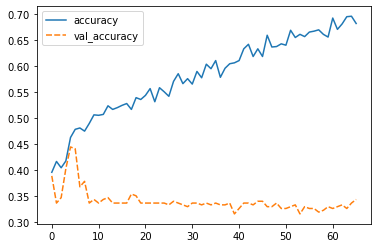

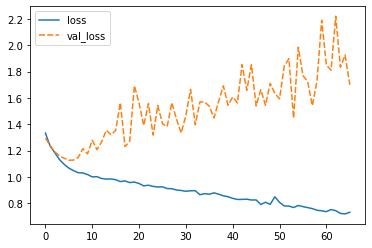

In [22]:
ac = {'accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']}
plt.figure()
sb.lineplot(data=ac)

loss = {'loss': history.history['loss'], 'val_loss': history.history['val_loss']}
plt.figure()
sb.lineplot(data=loss)

In [23]:
y_pred = model_merged.predict([x1_test, x2_test])
y_pred_labeled = pd.DataFrame(y_pred, columns=[-1, 0, 1], index=y_test.index)
y_pred_labeled = y_pred_labeled.idxmax(axis=1)

In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_test_labeled, y_pred_labeled))


              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        91
           0       0.43      0.68      0.53        97
           1       0.45      0.61      0.52       100

    accuracy                           0.44       288
   macro avg       0.29      0.43      0.35       288
weighted avg       0.30      0.44      0.36       288



/home/solon/anaconda3/envs/Ptyxiaki/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
